## Setup

In [8]:
import numpy as np 
import pickle
import pandas as pd
from tqdm import tqdm

import multicam

from scipy import spatial

import pandas as pd


In [3]:
import matplotlib.pyplot as plt


In [4]:
metadata_file = "../../data/processed/tng/tng300-1-table.csv"
tng_snapshot_dir = "../../data/processed/tng/TNG300-1/"  # everything is a host halo
tng_dark_snapshot_dir = "../../data/processed/tng/TNG300-1-Dark/"

trees_file = "../../data/processed/tng/TNG300-1_cut_trees.p"
present_snapfile = tng_snapshot_dir + "TNG300-1_HaloHistory_MBP_snap99.hdf5"

dark_trees_file = "../../data/processed/tng/TNG300-1-Dark_cut_trees.p"
present_dark_snapfile = tng_dark_snapshot_dir + "TNG300-1-Dark_HaloHistory_MBP_snap99.hdf5"

color_file = "../../data/processed/tng/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_099.hdf5"


## Do matching

In [ ]:
dcat = pd.read_hdf(present_dark_snapfile) # dark matter only
cat = pd.read_hdf(present_snapfile) # hydro

len(dcat), len(cat)


In [17]:
# use a scipy kdtree to match haloes in in the dark matter and hydro catalogs
import scipy.spatial as spatial

# get positions 
pos = np.array(cat[['pos_x', 'pos_y', 'pos_z']])
dpos = np.array(dcat[['pos_x', 'pos_y', 'pos_z']])

# kdtree 
tree = spatial.KDTree(pos)
dtree = spatial.KDTree(dpos)


In [20]:
# find the nearest neighbor in the other catalog
d, indx = tree.query(dpos)
dd, dindx = dtree.query(pos)


In [23]:
len(dindx), len(indx)


(13643, 13000)

In [24]:
# number of bijections 
n_matches = 0
for ii in range(len(cat)):
    if ii == indx[dindx[ii]]:
        n_matches += 1
n_matches


12695

(array([  3.,  25.,  94., 138., 218., 316., 381., 436., 472., 589., 575.,
        573., 590., 590., 583., 544., 541., 464., 385., 451., 353., 334.,
        303., 289., 257., 258., 192., 190., 173., 159., 140., 143., 141.,
        112.,  91.,  97.,  88.,  81.,  70.,  67.,  56.,  58.,  71.,  41.,
         49.,  41.,  33.,  32.,  28.,  22.,  27.,  30.,  30.,  19.,  24.,
         19.,  14.,  19.,  20.,   9.,  13.,  22.,  14.,  13.,  11.,  15.,
         11.,  10.,   8.,  13.,   5.,   7.,   9.,  11.,  13.,   4.,   3.,
          8.,   9.,   5.,   5.,   3.,   4.,   6.,   8.,  10.,   3.,   2.,
          3.,   3.,   5.,   3.,   5.,   3.,   4.,   1.,   3.,   1.,   7.,
          5.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
         22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
         44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
         66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
         88.,  90.,  9

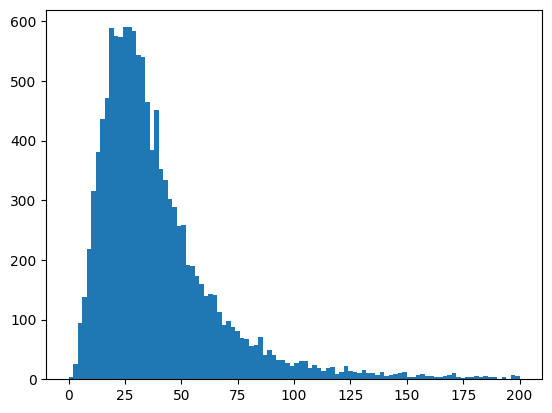

In [35]:
# plot the distribution of distances between matched haloes
plt.hist(dd, bins=100, range=(0, 200))


1073

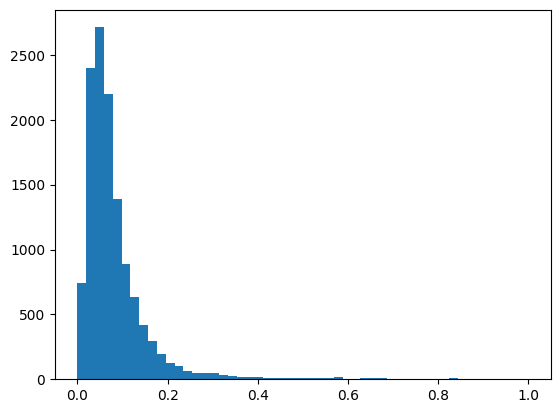

In [48]:
# plot virial radius to distance
plt.hist(dd/cat['Rvir'], bins=51, range=(0, 1))

sum(dd / cat['Rvir'] > 1)


In [49]:
# keep only bijectively matched haloes

# number of bijections 
keep = []
for ii in range(len(cat)):
    if ii == indx[dindx[ii]]:
        keep.append(ii)
keep = np.array(keep)

dkeep = [] 
for ii in range(len(dcat)):
    if ii == dindx[indx[ii]]:
        dkeep.append(ii)
dkeep = np.array(dkeep)

cat = cat.iloc[keep]
dcat = dcat.iloc[dkeep]

len(cat), len(dcat)


(12695, 12695)

In [54]:
sum(dd[keep] / cat['Rvir'] > 1)


9

## Investigate second neighbors

In [5]:
dcat = pd.read_hdf(present_dark_snapfile) # dark matter only
cat = pd.read_hdf(present_snapfile) # hydro

len(dcat), len(cat)


(13000, 13643)

In [21]:
# get positions
pos = np.array(cat[["pos_x", "pos_y", "pos_z"]])
dpos = np.array(dcat[["pos_x", "pos_y", "pos_z"]])

# construct kdtree
tree = spatial.KDTree(pos)
dtree = spatial.KDTree(dpos)

# kdtrees are fast but do not like custom metrics
# we can query multiple nearest neighbors at once and brute force among them with the correct metric
dist, indices = tree.query(dpos, k=2)



(array([2.875e+03, 3.473e+03, 2.172e+03, 1.305e+03, 8.380e+02, 4.970e+02,
        3.310e+02, 2.420e+02, 1.970e+02, 1.240e+02, 8.800e+01, 8.700e+01,
        5.400e+01, 3.900e+01, 4.200e+01, 2.600e+01, 2.100e+01, 2.000e+01,
        1.800e+01, 1.400e+01, 1.100e+01, 1.400e+01, 1.000e+01, 9.000e+00,
        6.000e+00, 1.200e+01, 9.000e+00, 6.000e+00, 6.000e+00, 7.000e+00,
        4.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 5.000e+00,
        4.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00]),
 array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568627,
        0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
        0.03921569, 0.04313725, 0.04705882, 0.05098039, 0.05490196,
        0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.0745098 ,
        0.07843137, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
        0.09803922, 0.101

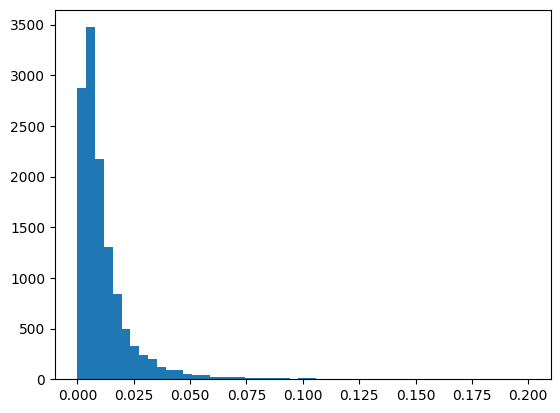

In [24]:
x = dist[:, 0] / dist[:, 1] 
plt.hist(x, bins=51, range=(0, 0.2))


In [ ]:
# now histogram of virial radii ratio between candidates and match
r1 = [] 
r2 = [] 
for ii, idx in enumerate(indices[:, 0]):
    r1.append(cat.iloc[idx]['Rvir'] / dcat.iloc[ii]['Rvir'])

for ii, idx in enumerate(indices[:, 1]):
    r2.append(cat.iloc[idx]['Rvir'] / dcat.iloc[ii]['Rvir'])

r1 = np.array(r1)
r2 = np.array(r2)


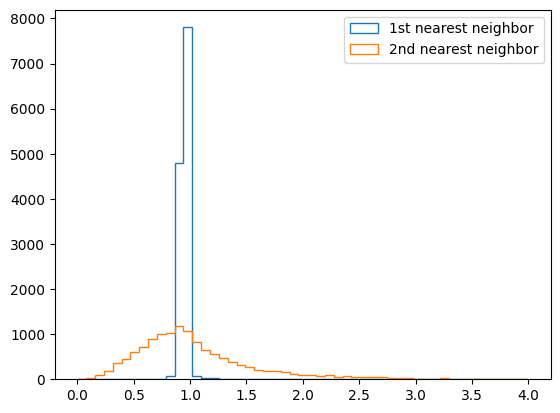

In [33]:

_, bins, _ = plt.hist(r1, bins=51, histtype='step', label='1st nearest neighbor', range=(0, 4))
plt.hist(r2, bins=bins, histtype='step', label='2nd nearest neighbor', range=(0, 4))

plt.legend()


In [34]:
d1 = [] 
d2 = [] 
for ii, idx in enumerate(indices[:, 0]):
    d1.append(dist[ii, 0] / cat.iloc[idx]['Rvir'])

for ii, idx in enumerate(indices[:, 1]):
    d2.append(dist[ii, 1] / cat.iloc[idx]['Rvir'])

d1 = np.array(d1)
d2 = np.array(d2)



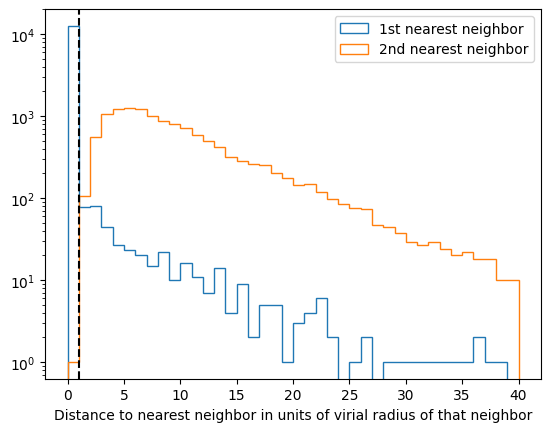

In [45]:

_, bins, _ = plt.hist(d1, bins=40, histtype='step', label='1st nearest neighbor', range=(0, 40))
plt.hist(d2, bins=bins, histtype='step', label='2nd nearest neighbor', range=(0, 40))
plt.xlabel("Distance to nearest neighbor in units of virial radius of that neighbor")
plt.legend()
plt.yscale('log')
plt.axvline(1, color='k', linestyle='--')


In [48]:
sum(d1 > d2) 


85

## Extract other properties and predict

In [39]:
from multicam.tng.utils import setup_mah_and_cat, get_msmhmr, get_color, match_dm_and_hydro_cat, SNAPS


ImportError: cannot import name 'setup_mah_and_cat' from 'multicam.tng.utils' (/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py)

In [ ]:
info = setup_mah_and_cat(trees_file, present_snapfile, metadata_file, SNAPS)
dinfo = setup_mah_and_cat(dark_trees_file, present_dark_snapfile, metadata_file, SNAPS)


/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:20: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)


In [ ]:
cat, mah, mvir, scales = info['present_cat'], info['m_peak'], info['gmass'], info['scales']
dcat, dmah, dmvir, _dscales = dinfo['present_cat'], dinfo['m_peak'], dinfo['gmass'], dinfo['scales']

assert np.all(scales == _dscales)


In [ ]:
# get colors 
color = get_color(color_file, cat) 
gr = color['sdss_g'].values - color['sdss_r'].values


In [ ]:
# get mean stellar mass - halo mass deviation 
msmhmr, _  = get_msmhmr(cat, mvir)


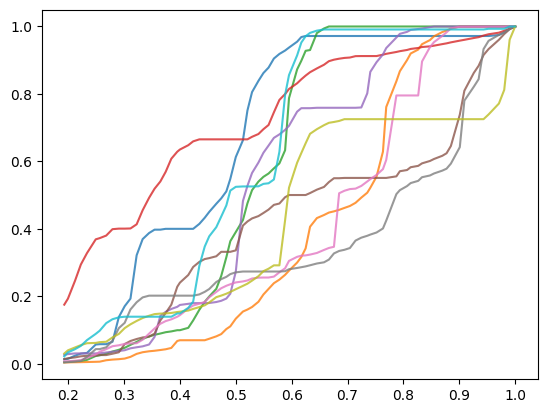

In [ ]:
# plot 10 random m_peaks as a function of scale 
for ii in range(10):
    idx = np.random.randint(0, len(mah))
    plt.plot(scales, mah[idx], '-', alpha=0.8
    );


In [ ]:
mydict = [{'a': 1, 'b': 2, 'c': 3, 'd': 4},

          {'a': 100, 'b': 200, 'c': 300, 'd': 400},

          {'a': 1000, 'b': 2000, 'c': 3000, 'd': 4000 }]

df = pd.DataFrame(mydict)


In [ ]:
df.iloc[[1, 0]]


,a,b,c,d
1,100,200,300,400
0,1,2,3,4
